In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skylark.utils import logger

import pickle
import json
import re
from pathlib import Path

data_dir = Path(globals()["_dh"][0]).parent / "data"
figure_dir = data_dir / "figures" / "throughput_gcp_premium_standard"
figure_dir.mkdir(exist_ok=True)

plt.style.use("seaborn-bright")
plt.set_cmap("plasma")

<Figure size 432x288 with 0 Axes>

In [94]:
date = "2021-12-03_01-08-21"
with (data_dir / "throughput" / "iperf3" / f"throughput_{date}.json").open("rb") as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.to_csv(data_dir / "throughput" / "iperf3" / f"throughput_{date}.csv")
df["throughput_gbps"] = df.throughput_sent / 1e9
df["src_network_tier"] = df["src_network_tier"].astype("category")
df["dst_network_tier"] = df["dst_network_tier"].astype("category")

# df.keys()
# Index(['congestion', 'src', 'dst', 'src_instance_class', 'dst_instance_class',
#        'src_network_tier', 'dst_network_tier', 'throughput_sent',
#        'throughput_received', 'throughput_gbps'],
#       dtype='object')

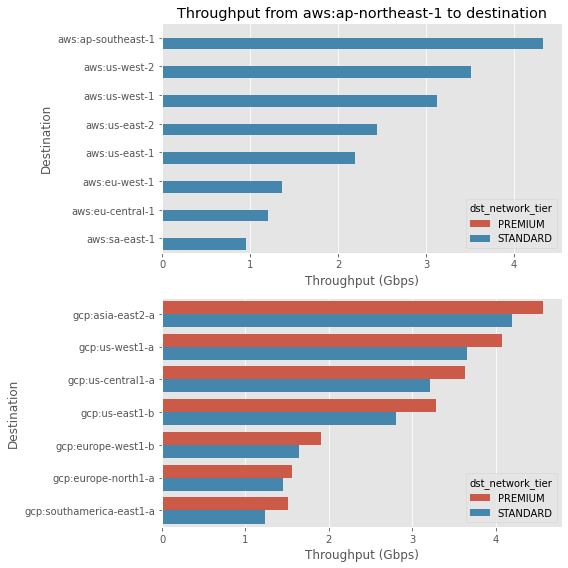

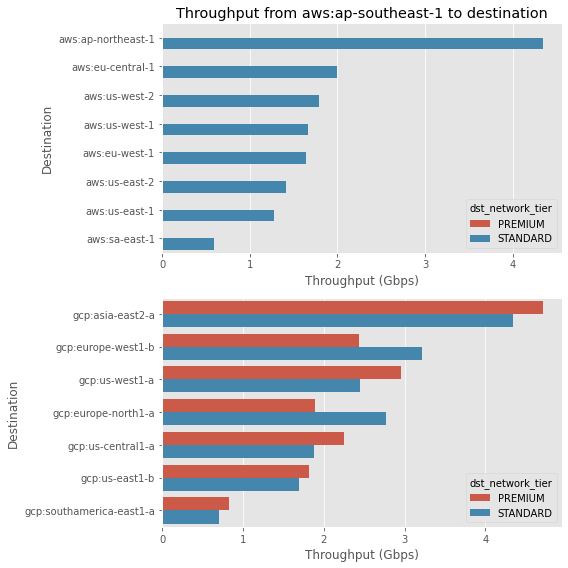

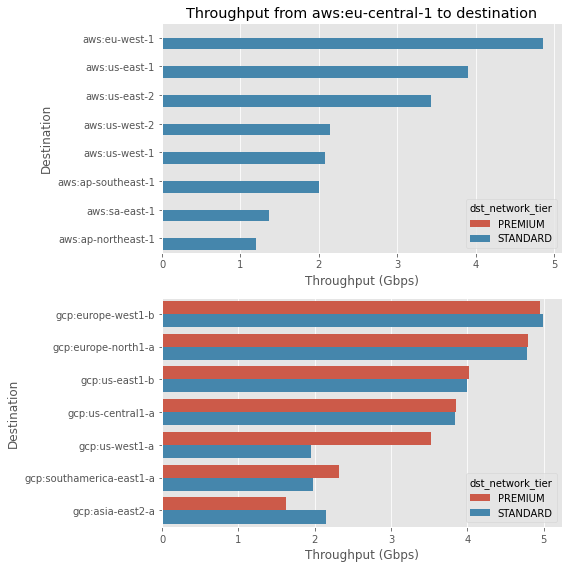

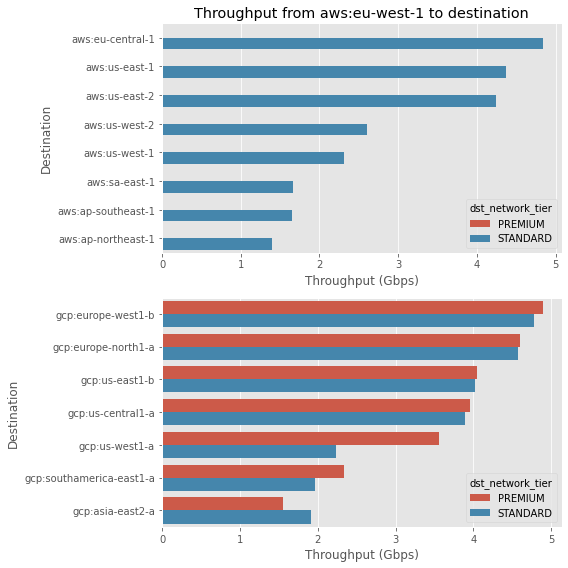

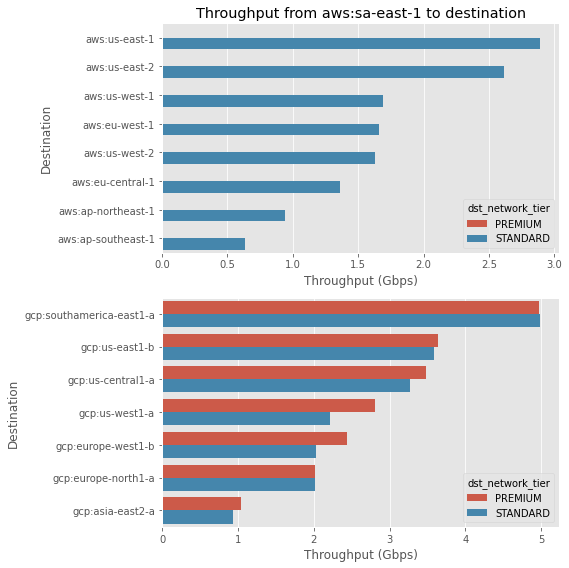

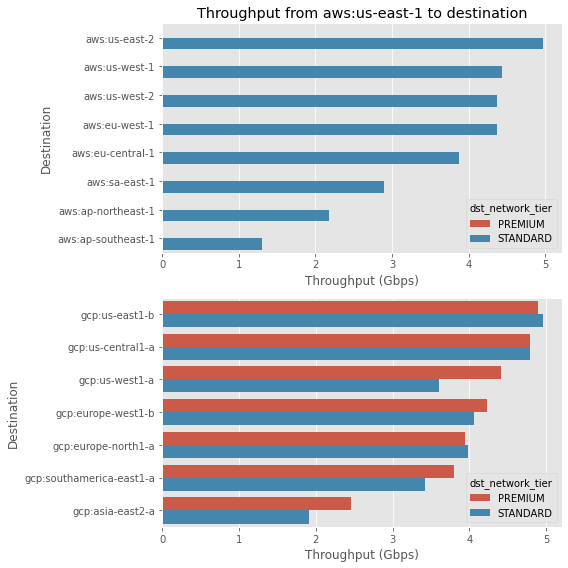

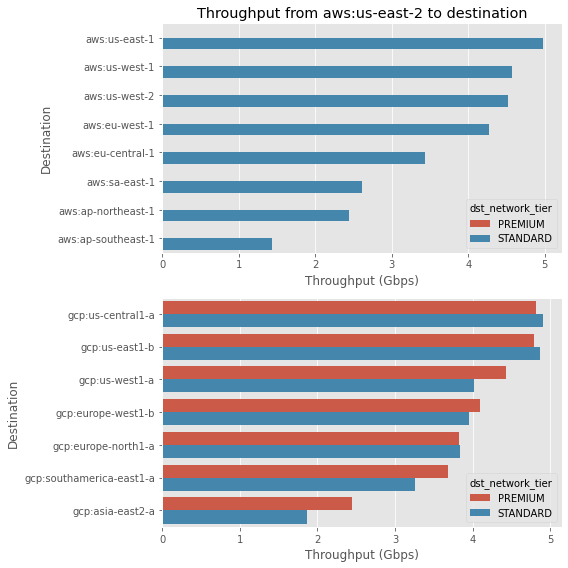

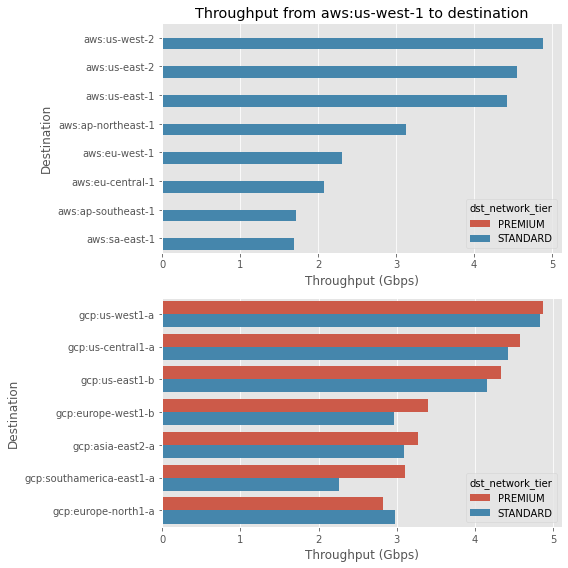

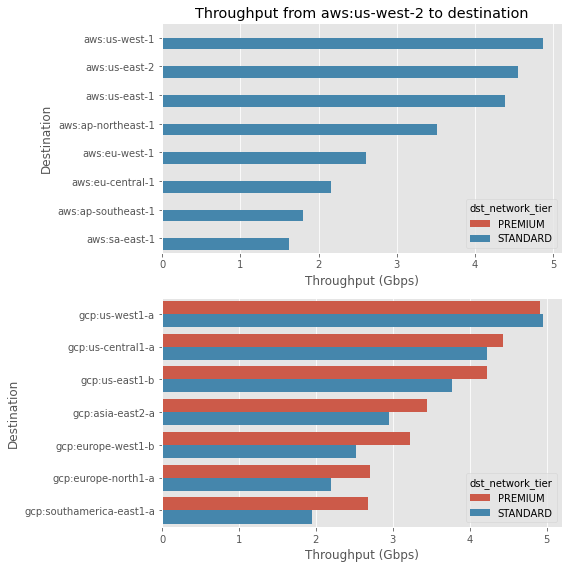

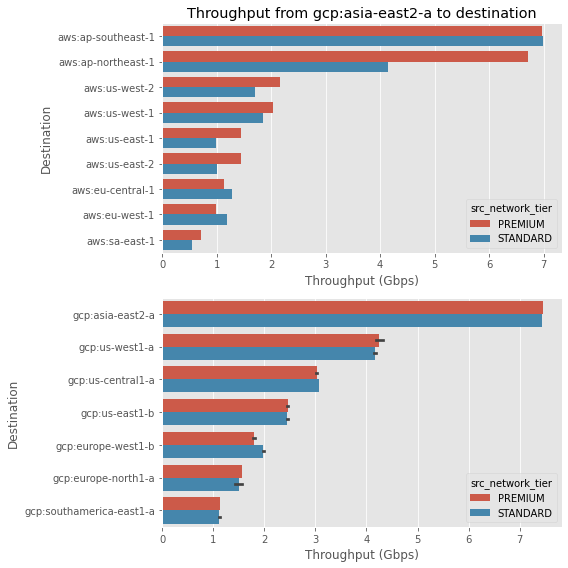

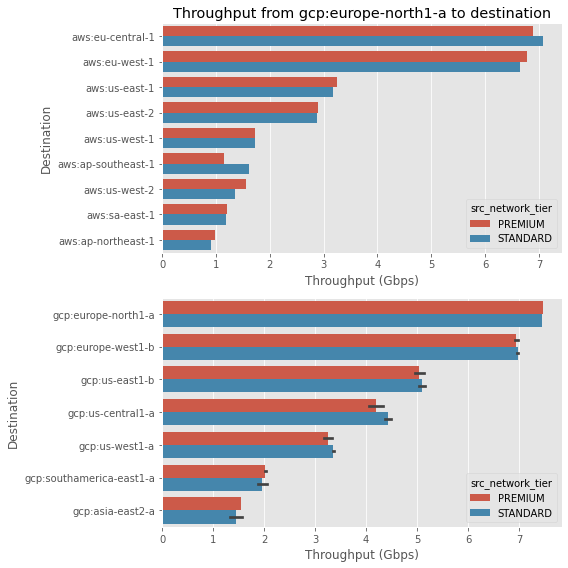

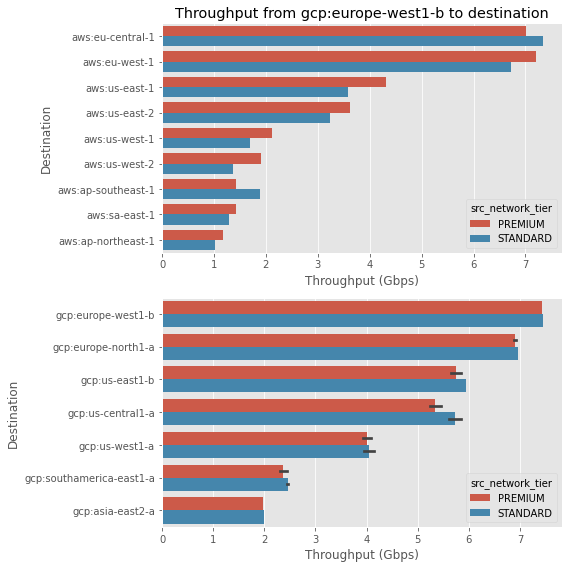

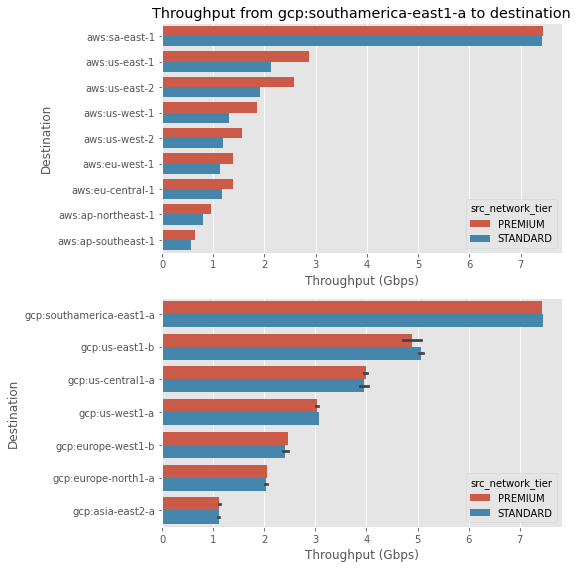

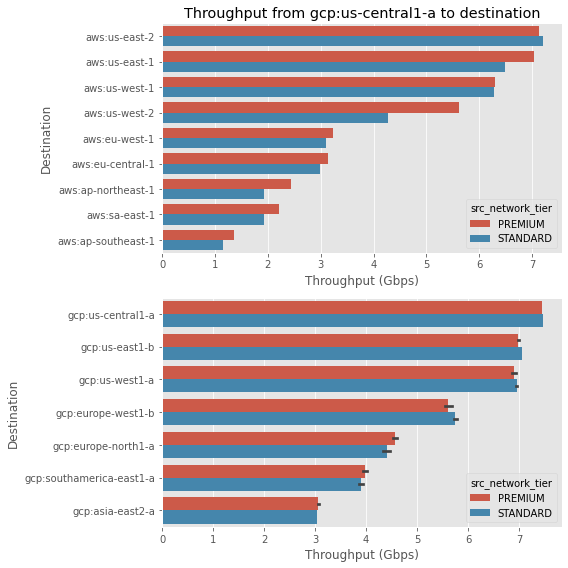

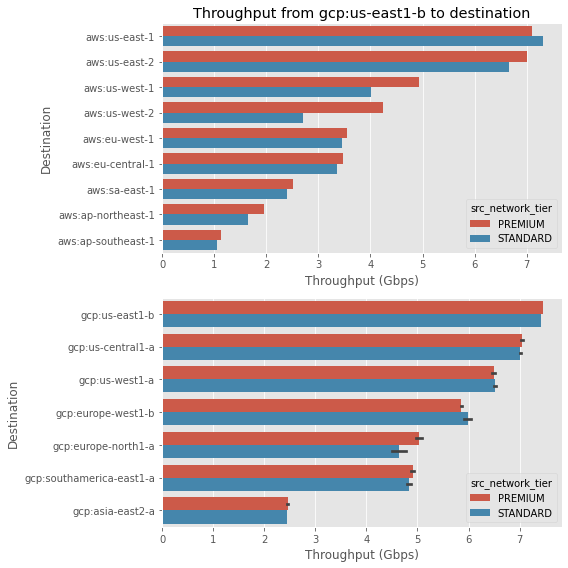

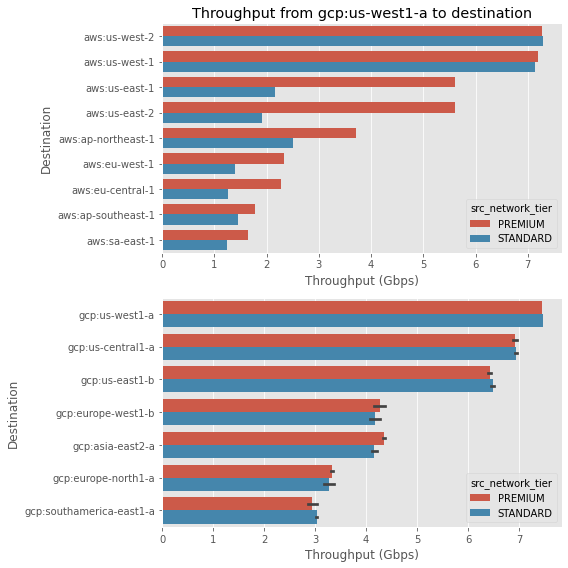

In [96]:
# plot bar chart with (src -> dst) throughput. one plot per src. show separate bar for each src_network_tier and dst_network_tier
# show two plots, one for aws dst and one for gcp dst
import seaborn as sns

# set style to ggplot
plt.style.use("ggplot")

df_plot = df.copy()
for src, group in df_plot.groupby("src"):
    group.sort_values("throughput_gbps", ascending=False, inplace=True)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    group_aws = group[group["dst"].str.startswith("aws")]

    hue = "src_network_tier" if src.startswith("gcp") else "dst_network_tier"

    sns.barplot(y="dst", x="throughput_gbps", hue=hue, data=group_aws, ax=ax[0], orient="h")
    ax[0].set_title(f"Throughput from {src} to destination")
    ax[0].set_xlabel("Throughput (Gbps)")
    ax[0].set_ylabel("Destination")
    group_gcp = group[group["dst"].str.startswith("gcp")]
    sns.barplot(y="dst", x="throughput_gbps", hue=hue, data=group_gcp, ax=ax[1], orient="h")
    ax[1].set_xlabel("Throughput (Gbps)")
    ax[1].set_ylabel("Destination")

    # tight layout
    fig.tight_layout()
    fig.savefig(figure_dir / f"{src}_throughput.pdf", bbox_inches="tight")